<a href="https://colab.research.google.com/github/HoodBlack/CNN_SKKU/blob/main/PreTrainedViT_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using PreTrained ViT with Fine_tuning



* DataLoader https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class


* Fine_tuning https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Fine_tuning_the_Vision_Transformer_on_CIFAR_10_with_the_%F0%9F%A4%97_Trainer.ipynb




In [1]:
!pip install -q transformers datasets
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install transformers[torch]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor
from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

In [4]:
import os
import torch
import json
from skimage import io, transform
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [5]:
from datasets import load_dataset

# load cifar10 (only small portion for demonstration purposes)
train_ds, test_ds = load_dataset('cifar10', split=['train[:5000]', 'test[:2000]'])
# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

  0%|          | 0/2 [00:00<?, ?it/s]

# 라벨링용 데이터 정리
변수설정 필요
*   folder_path
*   output_file

기본 변수명
* "image"
* "grades"



In [6]:
import pandas as pd


In [7]:
import os
import json
import csv

def json_to_csv(folder_path, output_file):
    # CSV 파일을 작성하기 위한 파일 핸들러를 엽니다.
    with open(output_file, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)

        writer.writerow(['file_name','grade'])
        # 폴더 내의 모든 파일에 대해 반복합니다.
        for filename in os.listdir(folder_path):
            if filename.endswith('.json'):  # JSON 파일인지 확인합니다.
                file_path = os.path.join(folder_path, filename)

                # JSON 파일을 읽어옵니다.
                with open(file_path, 'r') as json_file:
                    data = json.load(json_file)
                    file_name = data.get('label_info', {}).get('image', {}).get('file_name', '')
                    grade = data.get('label_info', {}).get('shapes', [{}])[0].get('grade', '')
                    writer.writerow([file_name, grade])

# 사용 예시
folder_path = '/content/drive/MyDrive/meat_data/라벨링데이터/1.소도체'  # JSON 파일들이 있는 폴더 경로로 변경해야 합니다.
output_file = '/content/drive/MyDrive/meat_data/원천데이터/1. 소도제/1.segmentation/1/meat_annot.csv' # 결과를 저장할 CSV 파일 경로로 변경해야 합니다.

json_to_csv(folder_path, output_file)


In [8]:
sample_label=pd.read_csv(output_file)
sample_label

,file_name,grade
0,QC_cow_segmentation_1_000281.jpg,1
1,QC_cow_segmentation_1_000105.jpg,1
2,QC_cow_segmentation_1_000089.jpg,1
3,QC_cow_segmentation_1_000211.jpg,1
4,QC_cow_segmentation_1_000194.jpg,1
...,...,...
995,QC_cow_segmentation_1_060249.jpg,1
996,QC_cow_segmentation_1_060098.jpg,1
997,QC_cow_segmentation_1_060153.jpg,1
998,QC_cow_segmentation_1_060056.jpg,1


# Dataloader 생성_1
변수 설정 필요
*  csv_file
*  root_dir



In [25]:
class MeatDataset(Dataset):
    """meat dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.meat_data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.meat_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #header 제외가 필요할까? => 필요 없다.
        img_name = os.path.join(self.root_dir, self.meat_data.iloc[idx, 0]) # 첫 번째 column-> image_names
        image = io.imread(img_name)
        grade = self.meat_data.iloc[idx, 1]
        sample = {'image': image, 'grades': grade}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [26]:
Meat_datasets = MeatDataset(csv_file = '/content/drive/MyDrive/meat_data/원천데이터/1. 소도제/1.segmentation/1/meat_annot.csv' , root_dir = '/content/drive/MyDrive/meat_data/원천데이터/1. 소도제/1.segmentation/1')

In [27]:
Meat_datasets[0]['grades']

1

In [28]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, labels = sample['image'], sample['grades']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively

        return {'image': img, 'grades': labels}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, grade = sample['image'], sample['grades']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'grades': grade}

In [29]:
scale = Rescale(512)
composed = transforms.Compose([Rescale(512)])

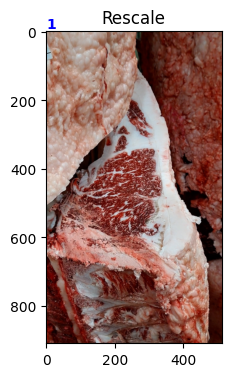

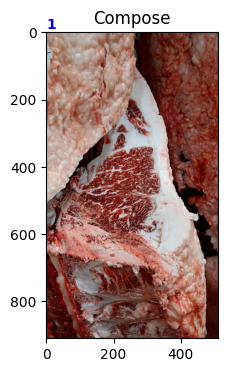

In [30]:
plt.figure()
sample=Meat_datasets[16]
for i, tsfrm in enumerate([scale,composed]):
  transformed_sample= tsfrm(sample)
  ax=plt.subplot(1,3,i+1)
  plt.tight_layout()
  ax.set_title(type(tsfrm).__name__)
  show_landmarks(**transformed_sample)
plt.show()

# Iterating Throught the dataset

In [31]:
transformed_meat = MeatDataset(csv_file ='/content/drive/MyDrive/meat_data/원천데이터/1. 소도제/1.segmentation/1/meat_annot.csv',root_dir='/content/drive/MyDrive/meat_data/원천데이터/1. 소도제/1.segmentation/1', transform = transforms.Compose([Rescale(512), ToTensor()]))

In [32]:
for i, sample in enumerate(transformed_meat):
    print(i, sample['image'].size(), sample['grades'])

    if i == 10:
        break

0 torch.Size([3, 910, 512]) 1
1 torch.Size([3, 910, 512]) 1
2 torch.Size([3, 910, 512]) 1
3 torch.Size([3, 910, 512]) 1
4 torch.Size([3, 910, 512]) 1
5 torch.Size([3, 910, 512]) 1
6 torch.Size([3, 910, 512]) 1
7 torch.Size([3, 910, 512]) 1
8 torch.Size([3, 910, 512]) 1
9 torch.Size([3, 910, 512]) 1
10 torch.Size([3, 910, 512]) 1


# Making Batch & Dataloder

*   num_workers를 활용한 multiprocessing 공부 필요




In [33]:
#일단 multi process를 사용하지 않습니다
dataloader = DataLoader(transformed_meat, batch_size =16, shuffle =True, num_workers=0)

0 torch.Size([16, 3, 910, 512]) tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
1 torch.Size([16, 3, 910, 512]) tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
2 torch.Size([16, 3, 910, 512]) tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
3 torch.Size([16, 3, 910, 512]) tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


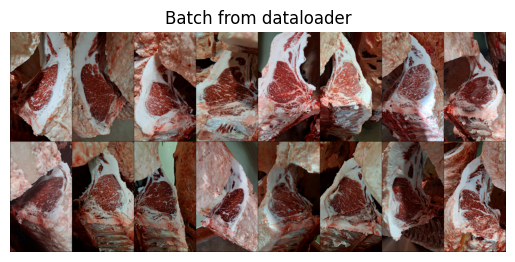

In [34]:
# Helper function to show a batch
def show_meat_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, grade = \
            sample_batched['image'], sample_batched['grades']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from dataloader')

# if you are using Windows, uncomment the next line and indent the for loop.
# you might need to go back and change ``num_workers`` to 0.

# if __name__ == '__main__':
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['grades'])

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_meat_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

# DataLoader 연결 & preprocessing

In [35]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

In [36]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [37]:
from torch.utils.data import DataLoader
import torch


In [68]:
transformed_meat.set_transform(train_transforms)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'MeatDataset' object has no attribute 'set_transform'

In [69]:
transformed_meat

In [38]:
#일단 multi process를 사용하지 않습니다
loadedMeat = DataLoader(transformed_meat, batch_size =16, shuffle =True, num_workers=0)

In [39]:
batch = next(iter(loadedMeat))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

image torch.Size([16, 3, 910, 512])
grades torch.Size([16])


# Getting pre-trained_0



In [ ]:
import torchvision
for name in dir(torchvision.models):
  print(name)

In [ ]:
#ViT_L_32_Weights

In [87]:
weights = torchvision.models.ViT_L_32_Weights.DEFAULT
model_loaded = torchvision.models.vit_l_32(weights=weights)

In [81]:
for param in model_loaded.features.parameters():
  param.requires_grad=False

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1614 in __getattr__           │
│                                                                                                  │
│   1611 │   │   │   modules = self.__dict__['_modules']                                           │
│   1612 │   │   │   if name in modules:                                                           │
│   1613 │   │   │   │   return modules[name]                                                      │
│ ❱ 1614 │   │   raise AttributeError("'{}' object has no attribute '{}'".format(                  │
│   1615 │   │   │   type(self).__name__, name))                                                   │
│   1616 │                                                                                         │
│   1617 │   def __setattr__(self, name: str, value: Union[Tensor, 'Module']) -> None:             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'VisionTransformer' object has no attribute 'features'

# Getting pre-trained model

*   ViT-base-patch 16-224



In [70]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TrainingArguments:
https://huggingface.co/docs/transformers/v4.30.0/en/main_classes/trainer#transformers.TrainingArguments

In [44]:


# 현재 작업 디렉토리 확인
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# 로그 디렉토리 경로 확인
logs_dir = os.path.join(current_dir, "logs")
print("Logs Directory:", logs_dir)


Current Directory: /content
Logs Directory: /content/logs


In [51]:
logs_dir = "/content/logs"

# 로그 디렉토리 생성
os.makedirs(logs_dir, exist_ok=True)

print("Logs Directory:", logs_dir)

Logs Directory: /content/logs


In [53]:

from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-meat-10",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='/content/logs',
    remove_unused_columns=False,
)

In [54]:
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [55]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [65]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir /content/logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-06-15 08:41:02.823426: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.33' not found (required by /usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server)
/usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.34' not found (required by /usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server)
/usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.32' not found (required by /usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server)
Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the s

In [66]:
trainer.train()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1645 in train                    │
│                                                                                                  │
│   1642 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1643 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1644 │   │   )                                                                                 │
│ ❱ 1645 │   │   return inner_training_loop(                                                       │
│   1646 │   │   │   args=args,                                                                    │
│   1647 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1648 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1916 in _inner_training_loop     │
│                                                                                                  │
│   1913 │   │   │   │   rng_to_sync = True                                                        │
│   1914 │   │   │                                                                                 │
│   1915 │   │   │   step = -1                                                                     │
│ ❱ 1916 │   │   │   for step, inputs in enumerate(epoch_iterator):                                │
│   1917 │   │   │   │   total_batched_samples += 1                                                │
│   1918 │   │   │   │   if rng_to_sync:                                                           │
│   1919 │   │   │   │   │   self._load_rng_state(resume_from_checkpoint)                          │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:633 in __next__           │
│                                                                                                  │
│    630 │   │   │   if self._sampler_iter is None:                                                │
│    631 │   │   │   │   # TODO(https://github.com/pytorch/pytorch/issues/76750)                   │
│    632 │   │   │   │   self._reset()  # type: ignore[call-arg]                                   │
│ ❱  633 │   │   │   data = self._next_data()                                                      │
│    634 │   │   │   self._num_yielded += 1                                                        │
│    635 │   │   │   if self._dataset_kind == _DatasetKind.Iterable and \                          │
│    636 │   │   │   │   │   self._IterableDataset_len_called is not None and \                    │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:677 in _next_data         │
│                                                                                                  │
│    674 │                                                                                         │
│    675 │   def _next_data(self):                                                                 │
│    676 │   │   index = self._next_index()  # may raise StopIteration                             │
│ ❱  677 │   │   data = self._dataset_fetcher.fetch(index)  # may raise StopIteration              │
│    678 │   │   if self._pin_memory:                        

# OutPuts

In [ ]:
outputs = trainer.predict(test_ds)

In [ ]:
print(outputs.metrics)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

# practice_1

In [19]:
# practice
root_dir='/content/drive/MyDrive/meat_data/원천데이터/1. 소도제/1.segmentation/1'

meat_data=pd.read_csv(output_file)
img_name=os.path.join(root_dir, meat_data.iloc[0,0] )
image=io.imread(img_name)
grade=meat_data.iloc[0,1]

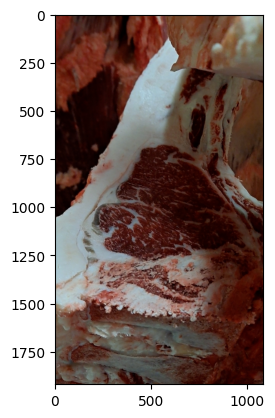

In [20]:
plt.imshow(image)

In [21]:
grade

1

In [22]:
len(meat_data)

1000

# practice_2

In [23]:
def show_landmarks(image, grades):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.text(0, -10, grade, color='b', fontweight='bold')
    plt.pause(0.001)  # pause a bit so that plots are updated

0 (1920, 1080, 3) ()


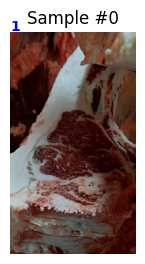

1 (1920, 1080, 3) ()


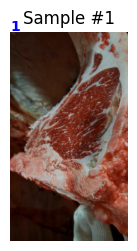

2 (1920, 1080, 3) ()


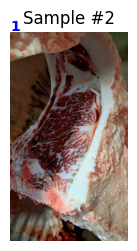

3 (1920, 1080, 3) ()


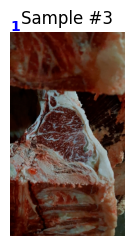

In [24]:
## remove this when executed on server
fig = plt.figure()
for i, sample in enumerate(Meat_datasets):
    print(i, sample['image'].shape, sample['grades'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break
